### Multi step model (simple encoder-decoder)

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder. 
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [148]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.20f}'.format
np.set_printoptions(precision=20)
warnings.filterwarnings("ignore")

In [173]:
df = pd.read_csv("Cleaned1.csv" , parse_dates = True)
a = pd.to_datetime(df['Epoch_Time_of_Clock'])
print(type(a[0]))
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1' ,'sqrt_A'  ,'PRN','SV_Clock_Bias', 'SV_Clock_Drift', 'SV_Clock_Drift_Rate', 'IODE', 'Crs',
       'Del_n', 'Cuc','Cus','Toe', 'Cic', 
       'Cis', 'Crc', 'M0', 'OMEGA_dot', 'I_dot', 'Codes', 'GPS_week',
       'L2_P_Data_flag', 'SV_accuracy', 'SV_health', 'Tgd', 'IODC', 'T_Tx',
       'Fit_Interval' ,'Epoch_Time_of_Clock' ],axis =1 )
df.head()
#df = df.set_index(['Epoch_Time_of_Clock'])
df = df.set_index(a)
df.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,e,OMEGA,i0,omega
Epoch_Time_of_Clock,,,,
2017-11-01 14:00:00,0.00709403527435000045,1.00937285970000001356,0.96871190895600001181,0.63272009923999994463
2017-11-01 16:00:00,0.00709456193727000042,1.00931255967999988776,0.96871347574200006303,0.63273892260700004275
2017-11-01 18:00:00,0.00709454016760000059,1.00925244690999993402,0.96871571254299992937,0.63268337999699997276
2017-11-01 20:00:00,0.00709462445228999962,1.00919191575000000149,0.96871721203500005259,0.63265364472399998608
2017-11-01 22:00:00,0.00709612155333000025,1.00913133191999992988,0.96871909334700001537,0.63270434800099994987


# Enter Variable Name

In [150]:
sat_var = 1
var_name = 'omega'

In [151]:
df.columns

Index(['e', 'OMEGA', 'omega'], dtype='object')

In [152]:

df = df.iloc[5 : , :]

In [153]:

df.head(7)

,e,OMEGA,omega
Epoch_Time_of_Clock,,,
2017-11-02 12:00:00,0.00709870201535999987,1.00870849592999989319,0.63246247790400000888
2017-11-02 14:00:00,0.00709954684135000007,1.00864845192999985635,0.63229294617900000386
2017-11-02 16:00:00,0.00709992146584999956,1.00858859223999997035,0.63230983703100007709
2017-11-02 18:00:00,0.00710008526221000014,1.00852901782999992975,0.63230376299500001824
2017-11-02 20:00:00,0.00710032973439000091,1.00846886117999989807,0.63223729823800001171
2017-11-02 22:00:00,0.00710155733395000013,1.00840879082999990146,0.63230010131100000681
2017-11-03 12:00:00,0.00710492231883000022,1.00799067275000009403,0.63232765829899995058


# Enter number of entries per day

In [154]:
entry = 6
print(df.shape[0])
no_of_entries = df.shape[0]//entry
valid = (no_of_entries * 70)//100
test = (no_of_entries * 85)//100
indexes = df.index
#print(valid , test , indexes)
valid_start_dt = indexes[int(valid)*int(entry)] 
test_start_dt = indexes [int(test)*int(entry)] 
test_start_dt = str(test_start_dt)
valid_start_dt = str(valid_start_dt)
print(test_start_dt,valid_start_dt)
print(type(test_start_dt))

168
2017-11-25 12:00:00 2017-11-21 12:00:00
<class 'str'>



Load data into Pandas dataframe

# enter lag and no. of outputs

In [155]:
"""total = len(df)
t = total*70/100
t = round(t)
indexes = df.index
valid_start_dt = str(indexes[t])
t = total*85/100
t = round(t)
test_start_dt = str(indexes[t])
print(valid_start_dt , test_start_dt)
"""
T = 6
HORIZON = 6

Create training set containing only the model features

In [156]:
train = df.copy()[df.index < valid_start_dt][['e', 'OMEGA', 'omega' ]]
train.head()

,e,OMEGA,omega
Epoch_Time_of_Clock,,,
2017-11-02 12:00:00,0.00709870201535999987,1.00870849592999989319,0.63246247790400000888
2017-11-02 14:00:00,0.00709954684135000007,1.00864845192999985635,0.63229294617900000386
2017-11-02 16:00:00,0.00709992146584999956,1.00858859223999997035,0.63230983703100007709
2017-11-02 18:00:00,0.00710008526221000014,1.00852901782999992975,0.63230376299500001824
2017-11-02 20:00:00,0.00710032973439000091,1.00846886117999989807,0.63223729823800001171


In [157]:
train.tail(6)

,e,OMEGA,omega
Epoch_Time_of_Clock,,,
2017-11-20 12:00:00,0.00711646664422000037,0.63499334812499996783,0.63062970780100002788
2017-11-20 14:00:00,0.00711591739672999980,0.63493855599100001985,0.63059641032300006724
2017-11-20 16:00:00,0.00711673183832000050,0.63488355319700007229,0.63077053268500005156
2017-11-20 18:00:00,0.00711753428914000015,0.63482873911899995178,0.63056012995499999274
2017-11-20 20:00:00,0.00711681041867000090,0.63477265961800000138,0.63053029374000002516
2017-11-20 22:00:00,0.00711733335629000010,0.63471711993299995136,0.63069974500500003423


Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

# Enter variable to be predicted

In [158]:
from sklearn.preprocessing import StandardScaler




y_scalar = StandardScaler()
y_scalar.fit(train[[var_name]])


X_scaler = StandardScaler()
train[['e', 'OMEGA', 'omega']] = X_scaler.fit_transform(train)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [159]:
tensor_structure = {'X':(range(-T+1, 1), ['e', 'OMEGA', 'omega'])}
train_inputs = TimeSeriesTensor(train, var_name, HORIZON, {'X':(range(-T+1, 1), ['e', 'OMEGA', 'omega'])} ,freq = None)

In [160]:
train_inputs.dataframe

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-02 22:00:00  0.80658668930844723555  0.51029756466224507339   
2017-11-03 12:00:00  0.51029756466224507339  0.51543818338990998740   
2017-11-03 14:00:00  0.51543818338990998740  0.57610759556977997331   
2017-11-03 16:00:00  0.57610759556977997331  0.44407830463047193170   
2017-11-03 18:00:00  0.44407830463047193170  0.53415155282490367483   
2017-11-03 20:00:00  0.53415155282490367483  0.99120691392514004292   
2017-11-03 22:00:00  0.99120691392514004292  0.78575139383041936458   
2017-11-04 12:00:00  0.78575139383041936458  0.76883408392202723380   
2017-11-04 14:00:00  0.76883408392202723380  0.79552235929752979082   
2017-11-04 16:00:00  0.79552235929752979082  0.71031438474593744381   
2017-11-04 18:00:00  0.71031438474593744381  0.75033795768062416798   
2017-11-04 20:00:00  0.75033795768062416798  1.29779243521901799241   
2017-11-04 22:00:00  1.29779243521901799241  1.24604269253540334006   
2017-11-05 12:00:00  1.24604269253540334006  1.23522339440477324501   
2017-11-05 14:00:00  1.23522339440477324501  1.09379447518572048281   
2017-11-05 16:00:00  1.09379447518572048281  1.10047854455312421607   
2017-11-05 18:00:00  1.10047854455312421607  1.08940158332075420766   
2017-11-05 20:00:00  1.08940158332075420766  1.33051304520138224952   
2017-11-05 22:00:00  1.33051304520138224952  1.43746318512219928287   
2017-11-06 12:00:00  1.43746318512219928287  1.47237645253395066369   
2017-11-06 14:00:00  1.47237645253395066369  1.10187042571692872528   
2017-11-06 16:00:00  1.10187042571692872528  1.19661191258787025227   
2017-11-06 18:00:00  1.19661191258787025227  1.16981754013331751274   
2017-11-06 20:00:00  1.16981754013331751274  0.88633322937738301395   
2017-11-06 22:00:00  0.88633322937738301395  1.10333051374924528965   
2017-11-07 12:00:00  1.10333051374924528965  1.21126330916306468310   
2017-11-07 14:00:00  1.21126330916306468310  0.68133493359471564155   
2017-11-07 16:00:00  0.68133493359471564155  0.81522090874259967030   
2017-11-07 18:00:00  0.81522090874259967030  0.82265270324617567610   
2017-11-07 20:00:00  0.82265270324617567610  0.10960713551924922138   
...                                     ...                     ...   
2017-11-15 12:00:00  0.74153449024088802233  0.62209529624281612037   
2017-11-15 14:00:00  0.62209529624281612037  0.56352507736145363015   
2017-11-15 16:00:00  0.56352507736145363015  0.63713066122663675195   
2017-11-15 18:00:00  0.63713066122663675195  0.65222665089262377158   
2017-11-15 20:00:00  0.65222665089262377158  0.25278916983891314141   
2017-11-15 22:00:00  0.25278916983891314141  0.26873645720266514658   
2017-11-16 12:00:00  0.26873645720266514658  0.17080197715296660532   
2017-11-16 14:00:00  0.17080197715296660532 -0.06117509655565678967   
2017-11-16 16:00:00 -0.06117509655565678967  0.01692947625373457388   
2017-11-16 18:00:00  0.01692947625373457388  0.08289107318357590015   
2017-11-16 20:00:00  0.08289107318357590015 -0.51452719076219877170   
2017-11-16 22:00:00 -0.51452719076219877170 -0.49590981342955342548   
2017-11-17 12:00:00 -0.49590981342955342548 -0.52159522681151071488   
2017-11-17 14:00:00 -0.52159522681151071488 -0.88853692153588392788   
2017-11-17 16:00:00 -0.88853692153588392788 -0.82572537508552712460   
2017-11-17 18:00:00 -0.82572537508552712460 -0.68523364068911885028   
2017-11-17 20:00:00 -0.68523364068911885028 -1.31830026768808261650   
2017-11-17 22:00:00 -1.31830026768808261650 -1.31182839247877947031   
2017-11-18 12:00:00 -1.31182839247877947031 -1.22957595968509281192   
2017-11-18 14:00:00 -1.22957595968509281192 -1.66510892312715230723   
2017-11-18 16:00:00 -1.66510892312715230723 -1.63402522791579007944   
2017-11-18 18:00:00 -1.6

In [161]:
train_inputs['target'].shape

(103, 6)

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [162]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][['e', 'OMEGA', 'omega']]
valid[['e', 'OMEGA', 'omega']] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, var_name, HORIZON, tensor_structure,freq = None)
valid_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -1.43936121899152835724 -1.56127852048089832415   
2017-11-22 12:00:00 -1.56127852048089832415 -1.20631307814756572050   
2017-11-22 14:00:00 -1.20631307814756572050 -1.34324048045132515838   
2017-11-22 16:00:00 -1.34324048045132515838 -1.45532366382071676192   
2017-11-22 18:00:00 -1.45532366382071676192 -1.27910525625223980839   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -1.20631307814756572050 -1.34324048045132515838   
2017-11-22 12:00:00 -1.34324048045132515838 -1.45532366382071676192   
2017-11-22 14:00:00 -1.45532366382071676192 -1.27910525625223980839   
2017-11-22 16:00:00 -1.27910525625223980839 -0.84551486587092894442   
2017-11-22 18:00:00 -0.84551486587092894442 -0.97781192143543460560   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -1.45532366382071676192 -1.27910525625223980839   
2017-11-22 12:00:00 -1.27910525625223980839 -0.84551486587092894442   
2017-11-22 14:00:00 -0.84551486587092894442 -0.97781192143543460560   
2017-11-22 16:00:00 -0.97781192143543460560 -0.68450865002476635190   
2017-11-22 18:00:00 -0.68450865002476635190 -0.71440507604446212842   

tensor                                   X                         \
feature                                  e                          
time step                              t-5                    t-4   
Epoch_Time_of_Clock                                                 
2017-11-21 22:00:00 0.25846325095622635359 0.19109481904778460870   
2017-11-22 12:00:00 0.19109481904778460870 0.30945855154248819163   
2017-11-22 14:00:00 0.30945855154248819163 0.44261091903228955147   
2017-11-22 16:00:00 0.44261091903228955147 0.37249238248652727368   
2017-11-22 18:00:00 0.37249238248652727368 0.41203195295805883358   

tensor                                                             ...  \
feature                                                            ...   
time step                              t-3                    t-2  ...   
Epoch_Time_of_Clock                                                ...   
2017-11-21 22:00:00 0.30945855154248819163 0.44261091903228955147  ...   
2017-11-22 12:00:00 0.44261091903228955147 0.37249238248652727368  ...   
2017-11-22 14:00:00 0.37249238248652727368 0.41203195295805883358  ...   
2017-11-22 16:00:00 0.41203195295805883358 0.65739219163440154592  ...   
2017-11-22 18:00:00 0.65739219163440154592 0.62400848403586117730  ...   

tensor                                                               \
feature                               OMEGA                           
time step                               t-3                     t-2   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -1.80296687995149529371 -1.80346860885906878913   
2017-11-22 12:00:00 -1.80346860885906878913 -1.80398083537509745788   
2017-11-22 14:00:00 -1.80398083537509745788 -1.80449141493681186610   
2017-11-22 16:00:00 -1.80449141493681186610 -1.80805118497488681584   
2017-11-22 18:00:00 -1.80805118497488681584 -1.80855488218232896003   

tensor                                                               \
feature                                                               
time step

## Implement the RNN

We will implement a RNN forecasting model with the following structure:

In [163]:
#Image('./images/simple_encoder_decoder.png')

In [164]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping ,ModelCheckpoint

In [165]:
LATENT_DIM = 64
BATCH_SIZE = 32
EPOCHS = 2000

In [166]:
model = Sequential()
model.add(LSTM(LATENT_DIM, input_shape=(T,3 ) , return_sequences=True))
model.add(LSTM(LATENT_DIM , return_sequences=True) )
model.add(LSTM(LATENT_DIM))
model.add(RepeatVector(HORIZON))
model.add(LSTM(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

In [167]:
model.compile(optimizer='RMSprop', loss='mse')

In [168]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 6, 64)             17408     
_________________________________________________________________
lstm_15 (LSTM)               (None, 6, 64)             33024     
_________________________________________________________________
lstm_16 (LSTM)               (None, 64)                33024     
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 6, 64)             0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 6, 64)             33024     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 6, 1)              65        
_________________________________________________________________
flatten_4 (Flatten)          (None, 6)                 0         
Total para

In [169]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2000)

In [170]:
best_val = ModelCheckpoint(str(sat_var) +'_' +  var_name + '_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [171]:
history = model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Train on 103 samples, validate on 13 samples
Epoch 1/2000
103/103 [==============================] - 3s 31ms/step - loss: 0.9260 - val_loss: 0.4185
Epoch 2/2000
103/103 [==============================] - 0s 851us/step - loss: 0.7130 - val_loss: 0.4779
Epoch 3/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.4302 - val_loss: 2.9151
Epoch 4/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.3522 - val_loss: 0.3549
Epoch 5/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.3637 - val_loss: 1.6153
Epoch 6/2000
103/103 [==============================] - 0s 2ms/step - loss: 0.2916 - val_loss: 0.5255
Epoch 7/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.3077 - val_loss: 1.3543
Epoch 8/2000
103/103 [==============================] - 0s 2ms/step - loss: 0.2708 - val_loss: 0.5092
Epoch 9/2000
103/103 [==============================] - 0s 2ms/step - loss: 0.2836 - val_loss: 1.2195
Epoch 10/2000
103/103 [===========

103/103 [==============================] - 0s 1ms/step - loss: 0.0546 - val_loss: 1.2016
Epoch 81/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.0544 - val_loss: 1.2670
Epoch 82/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.0539 - val_loss: 1.0803
Epoch 83/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.0342 - val_loss: 1.1769
Epoch 84/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.0403 - val_loss: 1.0210
Epoch 85/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.0418 - val_loss: 1.3489
Epoch 86/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.0500 - val_loss: 0.8830
Epoch 87/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.0383 - val_loss: 1.4790
Epoch 88/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.9433
Epoch 89/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.0532 - v

103/103 [==============================] - 0s 1ms/step - loss: 0.0471 - val_loss: 0.9451
Epoch 160/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 1.1535
Epoch 161/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.8851
Epoch 162/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 1.2357
Epoch 163/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.0352 - val_loss: 0.9513
Epoch 164/2000
103/103 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 1.2668
Epoch 165/2000
103/103 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.8716
Epoch 166/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.0352 - val_loss: 1.4030
Epoch 167/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.0490 - val_loss: 0.9384
Epoch 168/2000
103/103 [==============================] - 0s 1ms/step - loss: 0

103/103 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.8102
Epoch 238/2000
103/103 [==============================] - 0s 750us/step - loss: 0.0339 - val_loss: 1.2585
Epoch 239/2000
103/103 [==============================] - 0s 3ms/step - loss: 0.0372 - val_loss: 0.8823
Epoch 240/2000
103/103 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 1.0838
Epoch 241/2000
103/103 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.8559
Epoch 242/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 1.0604
Epoch 243/2000
103/103 [==============================] - 0s 595us/step - loss: 0.0323 - val_loss: 0.8921
Epoch 244/2000
103/103 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 1.3687
Epoch 245/2000
103/103 [==============================] - 0s 961us/step - loss: 0.0352 - val_loss: 0.8463
Epoch 246/2000
103/103 [==============================] - 0s 2ms/step - l

103/103 [==============================] - 0s 539us/step - loss: 0.0358 - val_loss: 1.3409
Epoch 315/2000
103/103 [==============================] - 0s 540us/step - loss: 0.0422 - val_loss: 0.9156
Epoch 316/2000
103/103 [==============================] - 0s 541us/step - loss: 0.0282 - val_loss: 0.9784
Epoch 317/2000
103/103 [==============================] - 0s 549us/step - loss: 0.0238 - val_loss: 0.9268
Epoch 318/2000
103/103 [==============================] - 0s 550us/step - loss: 0.0243 - val_loss: 0.9727
Epoch 319/2000
103/103 [==============================] - 0s 537us/step - loss: 0.0231 - val_loss: 1.1230
Epoch 320/2000
103/103 [==============================] - 0s 536us/step - loss: 0.0271 - val_loss: 1.0618
Epoch 321/2000
103/103 [==============================] - 0s 543us/step - loss: 0.0285 - val_loss: 1.0427
Epoch 322/2000
103/103 [==============================] - 0s 539us/step - loss: 0.0340 - val_loss: 0.7037
Epoch 323/2000
103/103 [==============================] - 0s 

103/103 [==============================] - 0s 546us/step - loss: 0.0318 - val_loss: 0.9225
Epoch 392/2000
103/103 [==============================] - 0s 547us/step - loss: 0.0318 - val_loss: 1.0967
Epoch 393/2000
103/103 [==============================] - 0s 543us/step - loss: 0.0280 - val_loss: 0.8582
Epoch 394/2000
103/103 [==============================] - 0s 540us/step - loss: 0.0257 - val_loss: 1.2609
Epoch 395/2000
103/103 [==============================] - 0s 543us/step - loss: 0.0323 - val_loss: 0.9394
Epoch 396/2000
103/103 [==============================] - 0s 544us/step - loss: 0.0312 - val_loss: 1.0892
Epoch 397/2000
103/103 [==============================] - 0s 544us/step - loss: 0.0274 - val_loss: 0.8855
Epoch 398/2000
103/103 [==============================] - 0s 560us/step - loss: 0.0248 - val_loss: 1.2582
Epoch 399/2000
103/103 [==============================] - 0s 530us/step - loss: 0.0309 - val_loss: 0.9588
Epoch 400/2000
103/103 [==============================] - 0s 

103/103 [==============================] - 0s 548us/step - loss: 0.0302 - val_loss: 1.1838
Epoch 469/2000
103/103 [==============================] - 0s 544us/step - loss: 0.0281 - val_loss: 0.9085
Epoch 470/2000
103/103 [==============================] - 0s 739us/step - loss: 0.0262 - val_loss: 1.2737
Epoch 471/2000
103/103 [==============================] - 0s 560us/step - loss: 0.0318 - val_loss: 1.0006
Epoch 472/2000
103/103 [==============================] - 0s 551us/step - loss: 0.0290 - val_loss: 1.1349
Epoch 473/2000
103/103 [==============================] - 0s 563us/step - loss: 0.0260 - val_loss: 0.9494
Epoch 474/2000
103/103 [==============================] - 0s 542us/step - loss: 0.0244 - val_loss: 1.2927
Epoch 475/2000
103/103 [==============================] - 0s 542us/step - loss: 0.0304 - val_loss: 1.0141
Epoch 476/2000
103/103 [==============================] - 0s 538us/step - loss: 0.0307 - val_loss: 1.1567
Epoch 477/2000
103/103 [==============================] - 0s 

103/103 [==============================] - 0s 537us/step - loss: 0.0280 - val_loss: 0.9099
Epoch 546/2000
103/103 [==============================] - 0s 539us/step - loss: 0.0271 - val_loss: 1.3339
Epoch 547/2000
103/103 [==============================] - 0s 570us/step - loss: 0.0294 - val_loss: 0.9918
Epoch 548/2000
103/103 [==============================] - 0s 534us/step - loss: 0.0258 - val_loss: 1.2037
Epoch 549/2000
103/103 [==============================] - 0s 565us/step - loss: 0.0237 - val_loss: 0.9618
Epoch 550/2000
103/103 [==============================] - 0s 536us/step - loss: 0.0245 - val_loss: 1.2347
Epoch 551/2000
103/103 [==============================] - 0s 550us/step - loss: 0.0277 - val_loss: 0.9911
Epoch 552/2000
103/103 [==============================] - 0s 581us/step - loss: 0.0301 - val_loss: 1.2386
Epoch 553/2000
103/103 [==============================] - 0s 584us/step - loss: 0.0247 - val_loss: 0.9108
Epoch 554/2000
103/103 [==============================] - 0s 

103/103 [==============================] - 0s 613us/step - loss: 0.0239 - val_loss: 1.2740
Epoch 623/2000
103/103 [==============================] - 0s 617us/step - loss: 0.0265 - val_loss: 1.0187
Epoch 624/2000
103/103 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 1.1632
Epoch 625/2000
103/103 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.9579
Epoch 626/2000
103/103 [==============================] - 0s 799us/step - loss: 0.0236 - val_loss: 1.2887
Epoch 627/2000
103/103 [==============================] - 0s 609us/step - loss: 0.0283 - val_loss: 1.0180
Epoch 628/2000
103/103 [==============================] - 0s 581us/step - loss: 0.0284 - val_loss: 1.1964
Epoch 629/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.9842
Epoch 630/2000
103/103 [==============================] - 0s 554us/step - loss: 0.0231 - val_loss: 1.3043
Epoch 631/2000
103/103 [==============================] - 0s 966us/

Epoch 700/2000
103/103 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 1.2277
Epoch 701/2000
103/103 [==============================] - 0s 3ms/step - loss: 0.0261 - val_loss: 0.8908
Epoch 702/2000
103/103 [==============================] - 0s 3ms/step - loss: 0.0263 - val_loss: 1.2667
Epoch 703/2000
103/103 [==============================] - 0s 3ms/step - loss: 0.0261 - val_loss: 0.9267
Epoch 704/2000
103/103 [==============================] - 0s 3ms/step - loss: 0.0272 - val_loss: 1.1702
Epoch 705/2000
103/103 [==============================] - 0s 3ms/step - loss: 0.0277 - val_loss: 0.9840
Epoch 706/2000
103/103 [==============================] - 0s 3ms/step - loss: 0.0239 - val_loss: 1.1749
Epoch 707/2000
103/103 [==============================] - 0s 3ms/step - loss: 0.0220 - val_loss: 0.9850
Epoch 708/2000
103/103 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 1.1864
Epoch 709/2000
103/103 [==============================] - 0s 2ms

103/103 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 1.2331
Epoch 779/2000
103/103 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.9715
Epoch 780/2000
103/103 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 1.1492
Epoch 781/2000
103/103 [==============================] - 0s 920us/step - loss: 0.0273 - val_loss: 0.9548
Epoch 782/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.0239 - val_loss: 1.1972
Epoch 783/2000
103/103 [==============================] - 0s 3ms/step - loss: 0.0243 - val_loss: 0.9786
Epoch 784/2000
103/103 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 1.1926
Epoch 785/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.0256 - val_loss: 0.9572
Epoch 786/2000
103/103 [==============================] - 0s 578us/step - loss: 0.0224 - val_loss: 1.2491
Epoch 787/2000
103/103 [==============================] - 0s 663us/step - l

103/103 [==============================] - 0s 584us/step - loss: 0.0219 - val_loss: 0.9661
Epoch 856/2000
103/103 [==============================] - 0s 573us/step - loss: 0.0240 - val_loss: 1.2081
Epoch 857/2000
103/103 [==============================] - 0s 697us/step - loss: 0.0250 - val_loss: 0.9929
Epoch 858/2000
103/103 [==============================] - 0s 593us/step - loss: 0.0220 - val_loss: 1.2451
Epoch 859/2000
103/103 [==============================] - 0s 610us/step - loss: 0.0218 - val_loss: 0.9603
Epoch 860/2000
103/103 [==============================] - 0s 600us/step - loss: 0.0236 - val_loss: 1.2218
Epoch 861/2000
103/103 [==============================] - 0s 613us/step - loss: 0.0239 - val_loss: 0.9760
Epoch 862/2000
103/103 [==============================] - 0s 601us/step - loss: 0.0217 - val_loss: 1.2620
Epoch 863/2000
103/103 [==============================] - 0s 591us/step - loss: 0.0218 - val_loss: 0.9738
Epoch 864/2000
103/103 [==============================] - 0s 

103/103 [==============================] - 0s 587us/step - loss: 0.0205 - val_loss: 1.2620
Epoch 933/2000
103/103 [==============================] - 0s 607us/step - loss: 0.0228 - val_loss: 1.0421
Epoch 934/2000
103/103 [==============================] - 0s 578us/step - loss: 0.0236 - val_loss: 1.2362
Epoch 935/2000
103/103 [==============================] - 0s 576us/step - loss: 0.0220 - val_loss: 0.9988
Epoch 936/2000
103/103 [==============================] - 0s 629us/step - loss: 0.0220 - val_loss: 1.2315
Epoch 937/2000
103/103 [==============================] - 0s 572us/step - loss: 0.0226 - val_loss: 1.0757
Epoch 938/2000
103/103 [==============================] - 0s 544us/step - loss: 0.0226 - val_loss: 1.2022
Epoch 939/2000
103/103 [==============================] - 0s 879us/step - loss: 0.0216 - val_loss: 1.0550
Epoch 940/2000
103/103 [==============================] - 0s 978us/step - loss: 0.0198 - val_loss: 1.2170
Epoch 941/2000
103/103 [==============================] - 0s 

103/103 [==============================] - 0s 542us/step - loss: 0.0203 - val_loss: 1.1082
Epoch 1010/2000
103/103 [==============================] - 0s 544us/step - loss: 0.0214 - val_loss: 1.2749
Epoch 1011/2000
103/103 [==============================] - 0s 644us/step - loss: 0.0234 - val_loss: 1.1149
Epoch 1012/2000
103/103 [==============================] - 0s 578us/step - loss: 0.0217 - val_loss: 1.2605
Epoch 1013/2000
103/103 [==============================] - 0s 550us/step - loss: 0.0214 - val_loss: 1.1671
Epoch 1014/2000
103/103 [==============================] - 0s 573us/step - loss: 0.0209 - val_loss: 1.2897
Epoch 1015/2000
103/103 [==============================] - 0s 533us/step - loss: 0.0215 - val_loss: 1.1253
Epoch 1016/2000
103/103 [==============================] - 0s 566us/step - loss: 0.0208 - val_loss: 1.3098
Epoch 1017/2000
103/103 [==============================] - 0s 590us/step - loss: 0.0209 - val_loss: 1.1440
Epoch 1018/2000
103/103 [============================

103/103 [==============================] - 0s 543us/step - loss: 0.0250 - val_loss: 1.1567
Epoch 1087/2000
103/103 [==============================] - 0s 554us/step - loss: 0.0224 - val_loss: 1.2814
Epoch 1088/2000
103/103 [==============================] - 0s 545us/step - loss: 0.0202 - val_loss: 1.2438
Epoch 1089/2000
103/103 [==============================] - 0s 541us/step - loss: 0.0181 - val_loss: 1.2822
Epoch 1090/2000
103/103 [==============================] - 0s 690us/step - loss: 0.0179 - val_loss: 1.2806
Epoch 1091/2000
103/103 [==============================] - 0s 612us/step - loss: 0.0184 - val_loss: 1.2150
Epoch 1092/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.0193 - val_loss: 1.3413
Epoch 1093/2000
103/103 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 1.1400
Epoch 1094/2000
103/103 [==============================] - 0s 895us/step - loss: 0.0250 - val_loss: 1.3196
Epoch 1095/2000
103/103 [==============================] 

Epoch 1163/2000
103/103 [==============================] - 0s 592us/step - loss: 0.0203 - val_loss: 1.2061
Epoch 1164/2000
103/103 [==============================] - 0s 586us/step - loss: 0.0201 - val_loss: 1.3434
Epoch 1165/2000
103/103 [==============================] - 0s 694us/step - loss: 0.0205 - val_loss: 1.1989
Epoch 1166/2000
103/103 [==============================] - 0s 697us/step - loss: 0.0198 - val_loss: 1.3671
Epoch 1167/2000
103/103 [==============================] - 0s 579us/step - loss: 0.0203 - val_loss: 1.2311
Epoch 1168/2000
103/103 [==============================] - 0s 573us/step - loss: 0.0210 - val_loss: 1.2990
Epoch 1169/2000
103/103 [==============================] - 0s 641us/step - loss: 0.0229 - val_loss: 1.2126
Epoch 1170/2000
103/103 [==============================] - 0s 571us/step - loss: 0.0198 - val_loss: 1.3362
Epoch 1171/2000
103/103 [==============================] - 0s 546us/step - loss: 0.0195 - val_loss: 1.2252
Epoch 1172/2000
103/103 [============

103/103 [==============================] - 0s 541us/step - loss: 0.0192 - val_loss: 1.2418
Epoch 1240/2000
103/103 [==============================] - 0s 533us/step - loss: 0.0198 - val_loss: 1.3116
Epoch 1241/2000
103/103 [==============================] - 0s 540us/step - loss: 0.0194 - val_loss: 1.2278
Epoch 1242/2000
103/103 [==============================] - 0s 539us/step - loss: 0.0181 - val_loss: 1.3675
Epoch 1243/2000
103/103 [==============================] - 0s 549us/step - loss: 0.0176 - val_loss: 1.2186
Epoch 1244/2000
103/103 [==============================] - 0s 556us/step - loss: 0.0181 - val_loss: 1.3813
Epoch 1245/2000
103/103 [==============================] - 0s 558us/step - loss: 0.0188 - val_loss: 1.2259
Epoch 1246/2000
103/103 [==============================] - 0s 562us/step - loss: 0.0199 - val_loss: 1.4008
Epoch 1247/2000
103/103 [==============================] - 0s 587us/step - loss: 0.0190 - val_loss: 1.1931
Epoch 1248/2000
103/103 [============================

Epoch 1316/2000
103/103 [==============================] - 0s 818us/step - loss: 0.0198 - val_loss: 1.4032
Epoch 1317/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.0205 - val_loss: 1.2583
Epoch 1318/2000
103/103 [==============================] - 0s 767us/step - loss: 0.0195 - val_loss: 1.3632
Epoch 1319/2000
103/103 [==============================] - 0s 945us/step - loss: 0.0190 - val_loss: 1.2562
Epoch 1320/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.0172 - val_loss: 1.3714
Epoch 1321/2000
103/103 [==============================] - 0s 561us/step - loss: 0.0175 - val_loss: 1.2632
Epoch 1322/2000
103/103 [==============================] - 0s 535us/step - loss: 0.0185 - val_loss: 1.3719
Epoch 1323/2000
103/103 [==============================] - 0s 543us/step - loss: 0.0195 - val_loss: 1.2878
Epoch 1324/2000
103/103 [==============================] - 0s 603us/step - loss: 0.0184 - val_loss: 1.3644
Epoch 1325/2000
103/103 [================

Epoch 1393/2000
103/103 [==============================] - 0s 566us/step - loss: 0.0175 - val_loss: 1.3247
Epoch 1394/2000
103/103 [==============================] - 0s 561us/step - loss: 0.0177 - val_loss: 1.4503
Epoch 1395/2000
103/103 [==============================] - 0s 548us/step - loss: 0.0181 - val_loss: 1.3031
Epoch 1396/2000
103/103 [==============================] - 0s 561us/step - loss: 0.0173 - val_loss: 1.4290
Epoch 1397/2000
103/103 [==============================] - 0s 561us/step - loss: 0.0183 - val_loss: 1.3420
Epoch 1398/2000
103/103 [==============================] - 0s 543us/step - loss: 0.0170 - val_loss: 1.4858
Epoch 1399/2000
103/103 [==============================] - 0s 564us/step - loss: 0.0196 - val_loss: 1.3085
Epoch 1400/2000
103/103 [==============================] - 0s 687us/step - loss: 0.0194 - val_loss: 1.4084
Epoch 1401/2000
103/103 [==============================] - 0s 565us/step - loss: 0.0192 - val_loss: 1.3200
Epoch 1402/2000
103/103 [============

103/103 [==============================] - 0s 2ms/step - loss: 0.0156 - val_loss: 1.3116
Epoch 1470/2000
103/103 [==============================] - 0s 534us/step - loss: 0.0164 - val_loss: 1.5114
Epoch 1471/2000
103/103 [==============================] - 0s 570us/step - loss: 0.0188 - val_loss: 1.3351
Epoch 1472/2000
103/103 [==============================] - 0s 2ms/step - loss: 0.0175 - val_loss: 1.4340
Epoch 1473/2000
103/103 [==============================] - 0s 2ms/step - loss: 0.0156 - val_loss: 1.3351
Epoch 1474/2000
103/103 [==============================] - 0s 727us/step - loss: 0.0152 - val_loss: 1.4541
Epoch 1475/2000
103/103 [==============================] - 0s 2ms/step - loss: 0.0166 - val_loss: 1.3484
Epoch 1476/2000
103/103 [==============================] - 0s 2ms/step - loss: 0.0182 - val_loss: 1.4525
Epoch 1477/2000
103/103 [==============================] - 0s 744us/step - loss: 0.0191 - val_loss: 1.3524
Epoch 1478/2000
103/103 [==============================] - 0s 3

Epoch 1546/2000
103/103 [==============================] - 0s 609us/step - loss: 0.0162 - val_loss: 1.4651
Epoch 1547/2000
103/103 [==============================] - 0s 585us/step - loss: 0.0147 - val_loss: 1.2501
Epoch 1548/2000
103/103 [==============================] - 0s 641us/step - loss: 0.0153 - val_loss: 1.4565
Epoch 1549/2000
103/103 [==============================] - 0s 859us/step - loss: 0.0161 - val_loss: 1.2645
Epoch 1550/2000
103/103 [==============================] - 0s 2ms/step - loss: 0.0172 - val_loss: 1.4067
Epoch 1551/2000
103/103 [==============================] - 0s 967us/step - loss: 0.0164 - val_loss: 1.3029
Epoch 1552/2000
103/103 [==============================] - 0s 564us/step - loss: 0.0143 - val_loss: 1.4147
Epoch 1553/2000
103/103 [==============================] - 0s 586us/step - loss: 0.0146 - val_loss: 1.3003
Epoch 1554/2000
103/103 [==============================] - 0s 548us/step - loss: 0.0152 - val_loss: 1.4753
Epoch 1555/2000
103/103 [==============

103/103 [==============================] - 0s 613us/step - loss: 0.0142 - val_loss: 1.4499
Epoch 1623/2000
103/103 [==============================] - 0s 594us/step - loss: 0.0155 - val_loss: 1.1446
Epoch 1624/2000
103/103 [==============================] - 0s 555us/step - loss: 0.0165 - val_loss: 1.3789
Epoch 1625/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.0153 - val_loss: 1.2123
Epoch 1626/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.0135 - val_loss: 1.3762
Epoch 1627/2000
103/103 [==============================] - 0s 1ms/step - loss: 0.0131 - val_loss: 1.2527
Epoch 1628/2000
103/103 [==============================] - 0s 550us/step - loss: 0.0137 - val_loss: 1.4526
Epoch 1629/2000
103/103 [==============================] - 0s 545us/step - loss: 0.0139 - val_loss: 1.2314
Epoch 1630/2000
103/103 [==============================] - 0s 552us/step - loss: 0.0151 - val_loss: 1.4355
Epoch 1631/2000
103/103 [==============================] - 

Epoch 1699/2000
103/103 [==============================] - 0s 613us/step - loss: 0.0129 - val_loss: 1.2360
Epoch 1700/2000
103/103 [==============================] - 0s 583us/step - loss: 0.0142 - val_loss: 1.3662
Epoch 1701/2000
103/103 [==============================] - 0s 610us/step - loss: 0.0136 - val_loss: 1.2354
Epoch 1702/2000
103/103 [==============================] - 0s 564us/step - loss: 0.0126 - val_loss: 1.3824
Epoch 1703/2000
103/103 [==============================] - 0s 547us/step - loss: 0.0130 - val_loss: 1.2340
Epoch 1704/2000
103/103 [==============================] - 0s 525us/step - loss: 0.0139 - val_loss: 1.3720
Epoch 1705/2000
103/103 [==============================] - 0s 539us/step - loss: 0.0139 - val_loss: 1.1722
Epoch 1706/2000
103/103 [==============================] - 0s 570us/step - loss: 0.0132 - val_loss: 1.4128
Epoch 1707/2000
103/103 [==============================] - 0s 585us/step - loss: 0.0123 - val_loss: 1.2194
Epoch 1708/2000
103/103 [============

103/103 [==============================] - 0s 564us/step - loss: 0.0117 - val_loss: 1.2103
Epoch 1776/2000
103/103 [==============================] - 0s 543us/step - loss: 0.0114 - val_loss: 1.0622
Epoch 1777/2000
103/103 [==============================] - 0s 574us/step - loss: 0.0103 - val_loss: 1.2663
Epoch 1778/2000
103/103 [==============================] - 0s 576us/step - loss: 0.0098 - val_loss: 1.0477
Epoch 1779/2000
103/103 [==============================] - 0s 776us/step - loss: 0.0107 - val_loss: 1.2367
Epoch 1780/2000
103/103 [==============================] - 0s 550us/step - loss: 0.0115 - val_loss: 1.1120
Epoch 1781/2000
103/103 [==============================] - 0s 553us/step - loss: 0.0106 - val_loss: 1.2413
Epoch 1782/2000
103/103 [==============================] - 0s 559us/step - loss: 0.0111 - val_loss: 1.0044
Epoch 1783/2000
103/103 [==============================] - 0s 545us/step - loss: 0.0111 - val_loss: 1.2460
Epoch 1784/2000
103/103 [============================

Epoch 1852/2000
103/103 [==============================] - 0s 3ms/step - loss: 0.0080 - val_loss: 0.9359
Epoch 1853/2000
103/103 [==============================] - 0s 594us/step - loss: 0.0087 - val_loss: 1.1627
Epoch 1854/2000
103/103 [==============================] - 0s 553us/step - loss: 0.0087 - val_loss: 0.9749
Epoch 1855/2000
103/103 [==============================] - 0s 592us/step - loss: 0.0081 - val_loss: 1.1103
Epoch 1856/2000
103/103 [==============================] - 0s 575us/step - loss: 0.0084 - val_loss: 0.9609
Epoch 1857/2000
103/103 [==============================] - 0s 546us/step - loss: 0.0076 - val_loss: 1.1284
Epoch 1858/2000
103/103 [==============================] - 0s 537us/step - loss: 0.0090 - val_loss: 0.9680
Epoch 1859/2000
103/103 [==============================] - 0s 554us/step - loss: 0.0076 - val_loss: 1.1172
Epoch 1860/2000
103/103 [==============================] - 0s 526us/step - loss: 0.0063 - val_loss: 1.0420
Epoch 1861/2000
103/103 [==============

103/103 [==============================] - 0s 535us/step - loss: 0.0062 - val_loss: 0.9297
Epoch 1929/2000
103/103 [==============================] - 0s 535us/step - loss: 0.0061 - val_loss: 1.1400
Epoch 1930/2000
103/103 [==============================] - 0s 536us/step - loss: 0.0060 - val_loss: 0.9566
Epoch 1931/2000
103/103 [==============================] - 0s 535us/step - loss: 0.0053 - val_loss: 1.1068
Epoch 1932/2000
103/103 [==============================] - 0s 529us/step - loss: 0.0061 - val_loss: 0.9780
Epoch 1933/2000
103/103 [==============================] - 0s 540us/step - loss: 0.0062 - val_loss: 1.1142
Epoch 1934/2000
103/103 [==============================] - 0s 550us/step - loss: 0.0068 - val_loss: 0.9204
Epoch 1935/2000
103/103 [==============================] - 0s 554us/step - loss: 0.0061 - val_loss: 1.1560
Epoch 1936/2000
103/103 [==============================] - 0s 537us/step - loss: 0.0048 - val_loss: 0.9437
Epoch 1937/2000
103/103 [============================

In [172]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights(str(sat_var) +'_' +  var_name + '_{:02d}.h5'.format(best_epoch))

In [147]:
 model.fit(valid_inputs['X'],
          valid_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=100,
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Epoch 1/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1187
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0911
Epoch 3/100
13/13 [==============================] - 0s 2ms/step - loss: 0.2057
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0426
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0388
Epoch 6/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0350
Epoch 7/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0343
Epoch 8/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0338
Epoch 9/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0367
Epoch 10/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0405
Epoch 11/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0538
Epoch 12/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0550
Epoch 13/100
13/13 [=================

## Evaluate the model

In [71]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = df.copy()[test_start_dt:][['e', 'OMEGA', 'omega']]
test[['e', 'OMEGA', 'omega']] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, var_name, HORIZON, tensor_structure,freq =None)
test_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.71488756279922882619 -0.76880470046970927900   
2017-11-26 12:00:00 -0.76880470046970927900 -0.82350493069577734850   
2017-11-26 14:00:00 -0.82350493069577734850 -0.76519237318943711390   
2017-11-26 16:00:00 -0.76519237318943711390 -0.81408762043275528786   
2017-11-26 18:00:00 -0.81408762043275528786 -1.10550894519194264909   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.82350493069577734850 -0.76519237318943711390   
2017-11-26 12:00:00 -0.76519237318943711390 -0.81408762043275528786   
2017-11-26 14:00:00 -0.81408762043275528786 -1.10550894519194264909   
2017-11-26 16:00:00 -1.10550894519194264909 -1.58193698922062453427   
2017-11-26 18:00:00 -1.58193698922062453427 -1.59611347777377043933   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.81408762043275528786 -1.10550894519194264909   
2017-11-26 12:00:00 -1.10550894519194264909 -1.58193698922062453427   
2017-11-26 14:00:00 -1.58193698922062453427 -1.59611347777377043933   
2017-11-26 16:00:00 -1.59611347777377043933 -1.71266533515592245251   
2017-11-26 18:00:00 -1.71266533515592245251 -1.71362020196184428045   

tensor                                   X                         \
feature                                  e                          
time step                              t-5                    t-4   
Epoch_Time_of_Clock                                                 
2017-11-25 22:00:00 1.39860886580713073002 1.48803276544208196164   
2017-11-26 12:00:00 1.48803276544208196164 1.43731065555048820315   
2017-11-26 14:00:00 1.43731065555048820315 1.48695822226151652679   
2017-11-26 16:00:00 1.48695822226151652679 1.64713809870233096611   
2017-11-26 18:00:00 1.64713809870233096611 1.53003103651788108230   

tensor                                                             ...  \
feature                                                            ...   
time step                              t-3                    t-2  ...   
Epoch_Time_of_Clock                                                ...   
2017-11-25 22:00:00 1.43731065555048820315 1.48695822226151652679  ...   
2017-11-26 12:00:00 1.48695822226151652679 1.64713809870233096611  ...   
2017-11-26 14:00:00 1.64713809870233096611 1.53003103651788108230  ...   
2017-11-26 16:00:00 1.53003103651788108230 1.58814746625392766433  ...   
2017-11-26 18:00:00 1.58814746625392766433 1.69594788624974257552  ...   

tensor                                                               \
feature                               OMEGA                           
time step                               t-3                     t-2   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -1.82770481597636758053 -1.82823045905599612659   
2017-11-26 12:00:00 -1.82823045905599612659 -1.82876275685983169517   
2017-11-26 14:00:00 -1.82876275685983169517 -1.82929449229750584749   
2017-11-26 16:00:00 -1.82929449229750584749 -2.93515827620206515292   
2017-11-26 18:00:00 -2.93515827620206515292 -2.93569044011878377276   

tensor                                                               \
feature                                                               
time step

In [72]:
test_inputs.dataframe.head(50)

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.71488756279922882619 -0.76880470046970927900   
2017-11-26 12:00:00 -0.76880470046970927900 -0.82350493069577734850   
2017-11-26 14:00:00 -0.82350493069577734850 -0.76519237318943711390   
2017-11-26 16:00:00 -0.76519237318943711390 -0.81408762043275528786   
2017-11-26 18:00:00 -0.81408762043275528786 -1.10550894519194264909   
2017-11-26 20:00:00 -1.10550894519194264909 -1.58193698922062453427   
2017-11-26 22:00:00 -1.58193698922062453427 -1.59611347777377043933   
2017-11-27 12:00:00 -1.59611347777377043933 -1.71266533515592245251   
2017-11-27 14:00:00 -1.71266533515592245251 -1.71362020196184428045   
2017-11-27 16:00:00 -1.71362020196184428045 -1.71602757806717276523   
2017-11-27 18:00:00 -1.71602757806717276523 -2.00273266896203505638   
2017-11-27 20:00:00 -2.00273266896203505638 -2.72925499529375015229   
2017-11-27 22:00:00 -2.72925499529375015229 -2.71693266643172304242   
2017-11-28 12:00:00 -2.71693266643172304242 -2.82275869154103453695   
2017-11-28 14:00:00 -2.82275869154103453695 -2.90708758143469081503   
2017-11-28 16:00:00 -2.90708758143469081503 -2.86510375345636170152   
2017-11-28 18:00:00 -2.86510375345636170152 -3.04369669595454395150   
2017-11-28 20:00:00 -3.04369669595454395150 -3.84123282457471049156   
2017-11-28 22:00:00 -3.84123282457471049156 -3.82513144494409296215   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.82350493069577734850 -0.76519237318943711390   
2017-11-26 12:00:00 -0.76519237318943711390 -0.81408762043275528786   
2017-11-26 14:00:00 -0.81408762043275528786 -1.10550894519194264909   
2017-11-26 16:00:00 -1.10550894519194264909 -1.58193698922062453427   
2017-11-26 18:00:00 -1.58193698922062453427 -1.59611347777377043933   
2017-11-26 20:00:00 -1.59611347777377043933 -1.71266533515592245251   
2017-11-26 22:00:00 -1.71266533515592245251 -1.71362020196184428045   
2017-11-27 12:00:00 -1.71362020196184428045 -1.71602757806717276523   
2017-11-27 14:00:00 -1.71602757806717276523 -2.00273266896203505638   
2017-11-27 16:00:00 -2.00273266896203505638 -2.72925499529375015229   
2017-11-27 18:00:00 -2.72925499529375015229 -2.71693266643172304242   
2017-11-27 20:00:00 -2.71693266643172304242 -2.82275869154103453695   
2017-11-27 22:00:00 -2.82275869154103453695 -2.90708758143469081503   
2017-11-28 12:00:00 -2.90708758143469081503 -2.86510375345636170152   
2017-11-28 14:00:00 -2.86510375345636170152 -3.04369669595454395150   
2017-11-28 16:00:00 -3.04369669595454395150 -3.84123282457471049156   
2017-11-28 18:00:00 -3.84123282457471049156 -3.82513144494409296215   
2017-11-28 20:00:00 -3.82513144494409296215 -3.85745040453474530295   
2017-11-28 22:00:00 -3.85745040453474530295 -4.01956557945350301253   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.81408762043275528786 -1.10550894519194264909   
2017-11-26 12:00:00 -1.10550894519194264909 -1.58193698922062453427   
2017-11-26 14:00:00 -1.58193698922062453427 -1.59611347777377043933   
2017-11-26 16:00:00 -1.59611347777377043933 -1.71266533515592245251   
2017-11-26 18:00:00 -1.71266533515592245251 -1.71362020196184428045   
2017-11-26 20:00:00 -1.71362020196184428045 -1.71602757806717276523   
2017-11-26 22:00:00 -1

In [73]:
test_inputs.dataframe.shape

(19, 24)

In [74]:
predictions = model.predict(test_inputs['X'])

In [75]:
predictions

array([[-0.11387476 , -0.14296739 , -0.14844142 , -0.14873727 ,
        -0.14980416 , -0.15279259 ],
       [-0.11437218 , -0.1433374  , -0.1487305  , -0.14909984 ,
        -0.1503532  , -0.15357907 ],
       [-0.114183545, -0.14306624 , -0.1486865  , -0.14949988 ,
        -0.15128548 , -0.15503813 ],
       [-0.11979404 , -0.14931478 , -0.15435492 , -0.15450512 ,
        -0.15582748 , -0.15932478 ],
       [-0.1374583  , -0.16858353 , -0.17085248 , -0.16761638 ,
        -0.16607492 , -0.1674358  ],
       [-0.15899576 , -0.19137426 , -0.18973257 , -0.18201415 ,
        -0.1767425  , -0.17532654 ],
       [-0.1644035  , -0.19677003 , -0.19414477 , -0.18557031 ,
        -0.17975755 , -0.17805573 ],
       [-0.17434503 , -0.20784548 , -0.20400758 , -0.19381712 ,
        -0.18658403 , -0.18378429 ],
       [-0.19461358 , -0.23002894 , -0.22337331 , -0.20960364 ,
        -0.19924073 , -0.19401091 ],
       [-0.2153198  , -0.25255033 , -0.24306214 , -0.22576025 ,
        -0.21233498 , -0.20

In [76]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scalar)
print(eval_df.head())
print(eval_df.tail())
print(eval_df.shape)


            timestamp    h             prediction                 actual
0 2017-11-25 22:00:00  t+1 0.63179460014647403909 0.63144654127700006185
1 2017-11-26 12:00:00  t+1 0.63179431208283698407 0.63141531675399997781
2 2017-11-26 14:00:00  t+1 0.63179442132454877168 0.63138363872600000715
3 2017-11-26 16:00:00  t+1 0.63179117217107183535 0.63141740872700002907
4 2017-11-26 18:00:00  t+1 0.63178094243855764667 0.63138909248399999186
              timestamp    h             prediction                 actual
109 2017-11-28 14:00:00  t+6 0.63170230645914293710 0.62964533509599995842
110 2017-11-28 16:00:00  t+6 0.63169522412023015878 0.62962661852199997004
111 2017-11-28 18:00:00  t+6 0.63168417195528847596 0.62953273429099998459
112 2017-11-28 20:00:00  t+6 0.63166442643174824934 0.62957288115199994127
113 2017-11-28 22:00:00  t+6 0.63165279484303737956 0.62958385303700004076
(114, 4)


In [77]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1   0.00150618939977695114
t+2   0.00162554642406295496
t+3   0.00179243934710066792
t+4   0.00197108176675403132
t+5   0.00214381451336661264
t+6   0.00230634315307437108
Name: APE, dtype: float64

In [78]:
mape(eval_df['prediction'], eval_df['actual'])
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(eval_df['prediction'], eval_df['actual'])
a

0.0011917391567827717

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

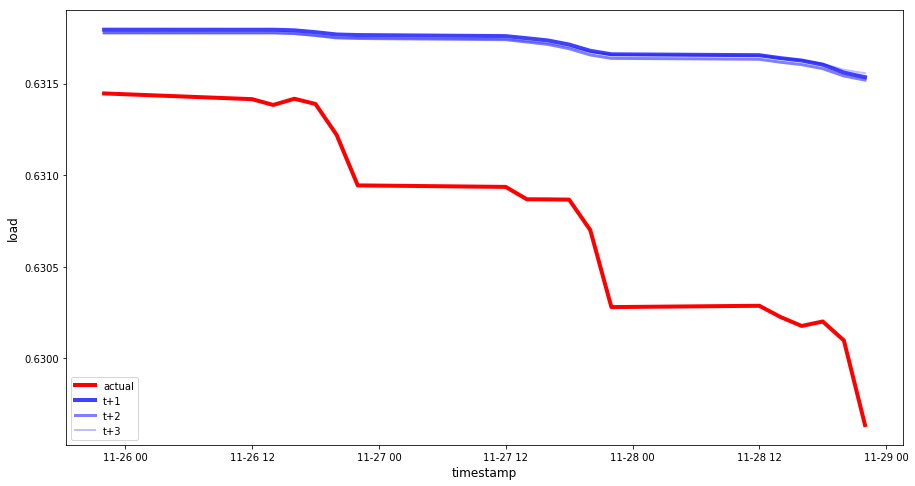

In [79]:
plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[ (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()

# take input here

In [80]:
a = df.iloc[156:162  , :]
a

,e,OMEGA,omega
Epoch_Time_of_Clock,,,
2017-11-28 12:00:00,0.00713293417356999915,0.50910438027500004576,0.63027997968000004647
2017-11-28 14:00:00,0.00713347224518999946,0.50904525936699995814,0.63028711579399998577
2017-11-28 16:00:00,0.00713335804176000021,0.50898615747599995629,0.63022582976700003421
2017-11-28 18:00:00,0.00713355280459000013,0.50892681859300004099,0.63017699317300002182
2017-11-28 20:00:00,0.00713495200033999969,0.50886720468199997391,0.63020130687099995548
2017-11-28 22:00:00,0.00713491823989999968,0.50880709484099995166,0.63009788002599997903


In [97]:
new_df = pd.DataFrame()

In [98]:
columns = ['e', 'OMEGA', 'omega'] 

In [99]:
for key , value in enumerate(columns):
    new_df[value] = a[value]

In [100]:
new_df = new_df.dropna( how = 'any')

In [101]:
new_df

,e,OMEGA,omega
Epoch_Time_of_Clock,,,
2017-11-28 12:00:00,0.00713293417356999915,0.50910438027500004576,0.63027997968000004647
2017-11-28 14:00:00,0.00713347224518999946,0.50904525936699995814,0.63028711579399998577
2017-11-28 16:00:00,0.00713335804176000021,0.50898615747599995629,0.63022582976700003421
2017-11-28 18:00:00,0.00713355280459000013,0.50892681859300004099,0.63017699317300002182
2017-11-28 20:00:00,0.00713495200033999969,0.50886720468199997391,0.63020130687099995548
2017-11-28 22:00:00,0.00713491823989999968,0.50880709484099995166,0.63009788002599997903


In [102]:
# creating index for output
import datetime
date = new_df.index.date[0]
date + datetime.timedelta(1)

datetime.date(2017, 11, 29)

In [103]:
import datetime
date = new_df.index + datetime.timedelta(days =1)

In [104]:
date

DatetimeIndex(['2017-11-29 12:00:00', '2017-11-29 14:00:00',
               '2017-11-29 16:00:00', '2017-11-29 18:00:00',
               '2017-11-29 20:00:00', '2017-11-29 22:00:00'],
              dtype='datetime64[ns]', name='Epoch_Time_of_Clock', freq='2H')

In [105]:
new_df.index= date

In [107]:
new_df.columns

Index(['e', 'OMEGA', 'omega'], dtype='object')

In [108]:
print(new_df)
print(new_df.columns)

                                         e                  OMEGA  \
Epoch_Time_of_Clock                                                 
2017-11-29 12:00:00 0.00713293417356999915 0.50910438027500004576   
2017-11-29 14:00:00 0.00713347224518999946 0.50904525936699995814   
2017-11-29 16:00:00 0.00713335804176000021 0.50898615747599995629   
2017-11-29 18:00:00 0.00713355280459000013 0.50892681859300004099   
2017-11-29 20:00:00 0.00713495200033999969 0.50886720468199997391   
2017-11-29 22:00:00 0.00713491823989999968 0.50880709484099995166   

                                     omega  
Epoch_Time_of_Clock                         
2017-11-29 12:00:00 0.63027997968000004647  
2017-11-29 14:00:00 0.63028711579399998577  
2017-11-29 16:00:00 0.63022582976700003421  
2017-11-29 18:00:00 0.63017699317300002182  
2017-11-29 20:00:00 0.63020130687099995548  
2017-11-29 22:00:00 0.63009788002599997903  
Index(['e', 'OMEGA', 'omega'], dtype='object')


In [109]:
freq = None
idx_tuples = []
drop_incomplete  = True
new_df[['e', 'OMEGA', 'omega']] = X_scaler.transform(new_df)
new_new_df = new_df.copy()
tensor_structure={'X':(range(-T+1, 1), ['e', 'OMEGA', 'omega'])}
for name, structure in tensor_structure.items():
        rng = structure[0]
        dataset_cols = structure[1]
        for col in dataset_cols:
        # do not shift non-sequential 'static' features
            if rng is None:
                new_df['context_'+col] = new_df[col]
                idx_tuples.append((name, col, 'static'))
            else:
                for t in rng:
                    sign = '+' if t > 0 else ''
                    shift = str(t) if t != 0 else ''
                    period = 't'+sign+shift
                    shifted_col = name+'_'+col+'_'+ period
                    new_new_df[shifted_col] = new_new_df[col].shift(t*-1, freq=freq)
                    idx_tuples.append((name, col, period))
        new_new_df = new_new_df.drop(new_df.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        print(new_df.head())
        new_new_df.columns = idx
        if drop_incomplete:
            new_new_df = new_new_df.dropna(how='any')
            
inputs = {}           
for name, structure in tensor_structure.items():
    rng = structure[0]
    cols = structure[1]
    tensor = new_new_df[name][cols].as_matrix()
    if rng is None:
        tensor = tensor.reshape(tensor.shape[0], len(cols))
    else:
        tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
        tensor = np.transpose(tensor, axes=[0, 2, 1])
    inputs[name] = tensor

                                         e                   OMEGA  \
Epoch_Time_of_Clock                                                  
2017-11-29 12:00:00 2.42927850077002238649 -2.94811737253914740720   
2017-11-29 14:00:00 2.51345717005090207863 -2.94865849421604053759   
2017-11-29 16:00:00 2.49559060283696210192 -2.94919944183418980543   
2017-11-29 18:00:00 2.52606029357211436803 -2.94974255859203537966   
2017-11-29 20:00:00 2.74495761489591449944 -2.95028819262537034263   

                                      omega  
Epoch_Time_of_Clock                          
2017-11-29 12:00:00 -2.72925499529375015229  
2017-11-29 14:00:00 -2.71693266643172304242  
2017-11-29 16:00:00 -2.82275869154103453695  
2017-11-29 18:00:00 -2.90708758143469081503  
2017-11-29 20:00:00 -2.86510375345636170152  


In [110]:
print(new_new_df)
print(inputs['X'])

tensor                                   X                         \
feature                                  e                          
time step                              t-5                    t-4   
Epoch_Time_of_Clock                                                 
2017-11-29 22:00:00 2.42927850077002238649 2.51345717005090207863   

tensor                                                             \
feature                                                             
time step                              t-3                    t-2   
Epoch_Time_of_Clock                                                 
2017-11-29 22:00:00 2.49559060283696210192 2.52606029357211436803   

tensor                                                             \
feature                                                             
time step                              t-1                      t   
Epoch_Time_of_Clock                                                 
2017-11-29 22:00:00 2.7449576148

In [111]:
predictions = model.predict(inputs['X'])

In [112]:
predictions

array([[-0.63877517, -0.5581424 , -0.49259844, -0.44567704, -0.42374152,
        -0.417297  ]], dtype=float32)

In [113]:
print(predictions.shape)


(1, 6)


In [114]:
results = predictions[-1, :]

In [115]:
results

array([-0.63877517, -0.5581424 , -0.49259844, -0.44567704, -0.42374152,
       -0.417297  ], dtype=float32)

In [116]:
res_df = pd.DataFrame(results , columns = [var_name])
res_df

,omega
0,-0.63877516984939575195
1,-0.55814242362976074219
2,-0.49259844422340393066
3,-0.44567704200744628906
4,-0.42374151945114135742
5,-0.41729700565338134766


In [117]:
res_df.index = date
res_df

,omega
Epoch_Time_of_Clock,
2017-11-29 12:00:00,-0.63877516984939575195
2017-11-29 14:00:00,-0.55814242362976074219
2017-11-29 16:00:00,-0.49259844422340393066
2017-11-29 18:00:00,-0.44567704200744628906
2017-11-29 20:00:00,-0.42374151945114135742
2017-11-29 22:00:00,-0.41729700565338134766


In [118]:
res_df[var_name] = y_scalar.inverse_transform(res_df[[var_name]])    

# final generated output 

In [119]:
# final generated ouput
res_df

,omega
Epoch_Time_of_Clock,
2017-11-29 12:00:00,0.63149064779281616211
2017-11-29 14:00:00,0.63153731822967529297
2017-11-29 16:00:00,0.63157528638839721680
2017-11-29 18:00:00,0.63160246610641479492
2017-11-29 20:00:00,0.63161516189575195312
2017-11-29 22:00:00,0.63161885738372802734


In [65]:
res_df.to_csv('SA1omega.csv')